# Aprendizado de Máquinas: Trabalho Final

In [2]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


### O Dataset

Para a realização deste trabalho foi utilizado o clássico dataset do [titanic](https://www.kaggle.com/competitions/titanic).

### Importando os Dados

In [16]:
# import the train data
train = pd.read_csv('data/train.csv')

# the test data is split into two parts
# import the test data
test = pd.read_csv('data/test.csv')
# import the dataset with the classes
gender = pd.read_csv('data/gender_submission.csv')
# merge the test data with it's classes
test = pd.merge(test, gender, on='PassengerId')

In [15]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Agora examinando algumas métricas das colunas numéricas:

In [4]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Usando o método `pd.Series.value_counts()` conseguimos ver que o dataset de treino contém dados referentes à $342$ sobreviventes e $549$ pessoas que não sobreviveram.

In [13]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

###

### data visualization

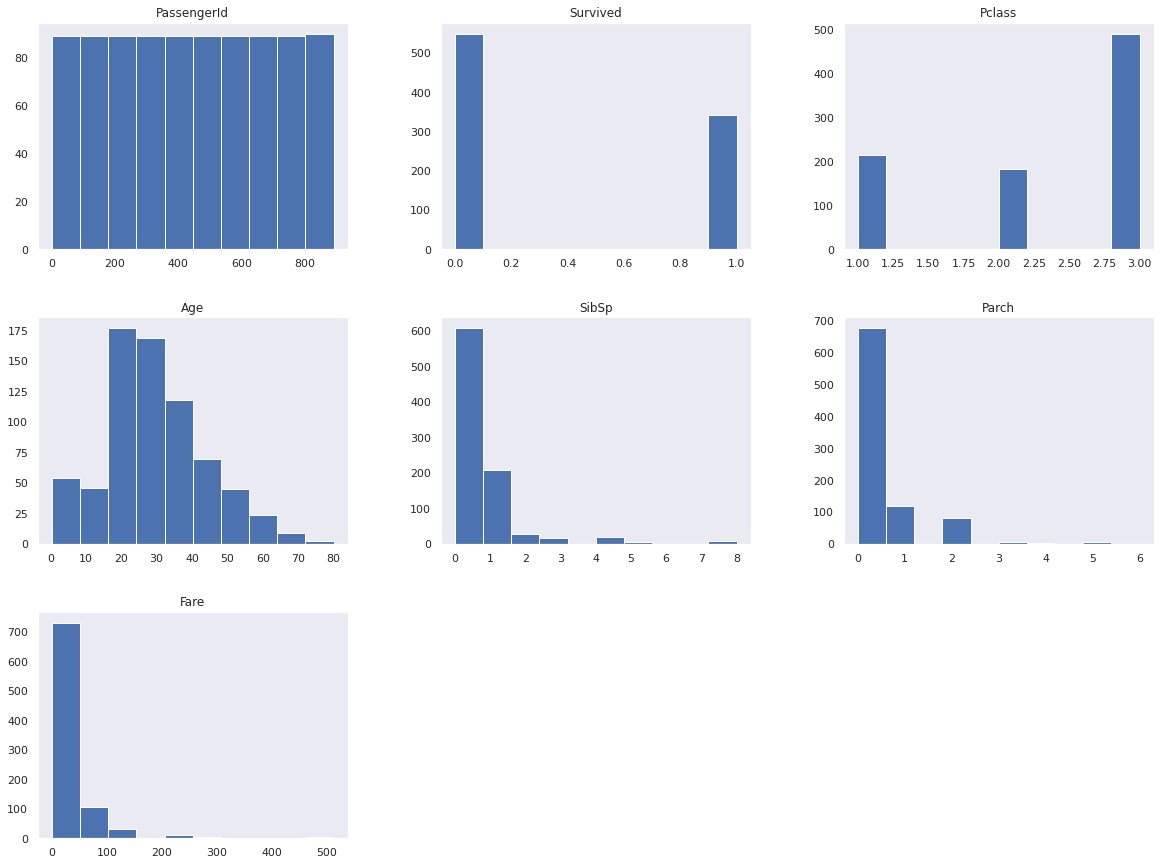

In [18]:
train.hist(
    bins = 10, 
    figsize=(20, 15), 
    grid=False, 
    sharex = False, 
    sharey=False
);

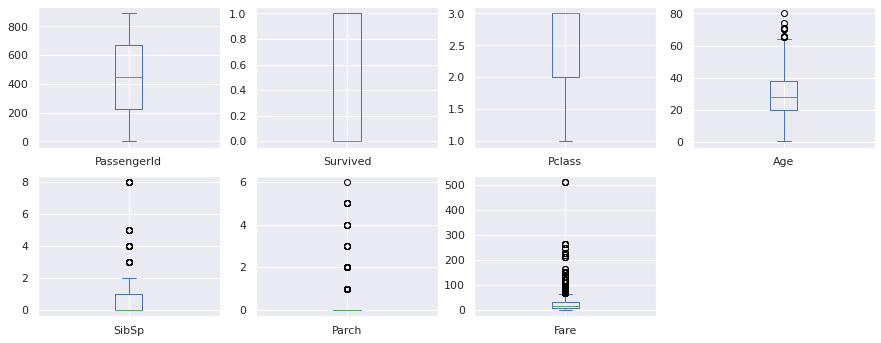

In [14]:
train.plot(kind='box', subplots=True, layout=(5, 4), sharex=False, sharey=False, figsize=(15, 15));

In [15]:
rs = np.random.RandomState(0)

# df = pd.DataFrame(rs.rand(20, 20))
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [21]:
train.corr().drop('Survived')['Survived']

PassengerId   -0.005007
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

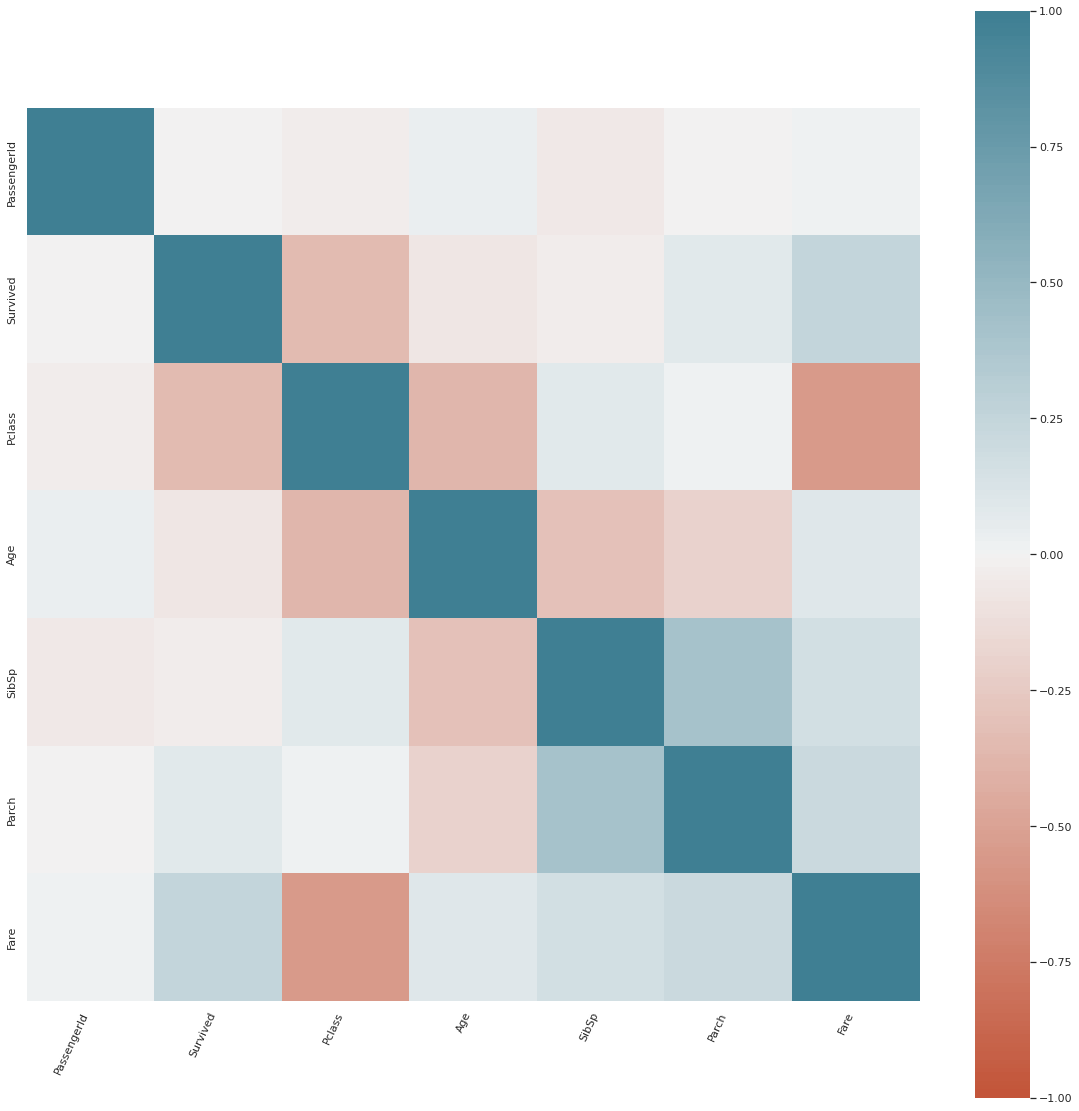

In [16]:
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.heatmap(   corr, 
                    vmin=-1, vmax=1, center=0, 
                    cmap=sns.diverging_palette(20, 220, n=200), 
                    square=True
                )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right'
);

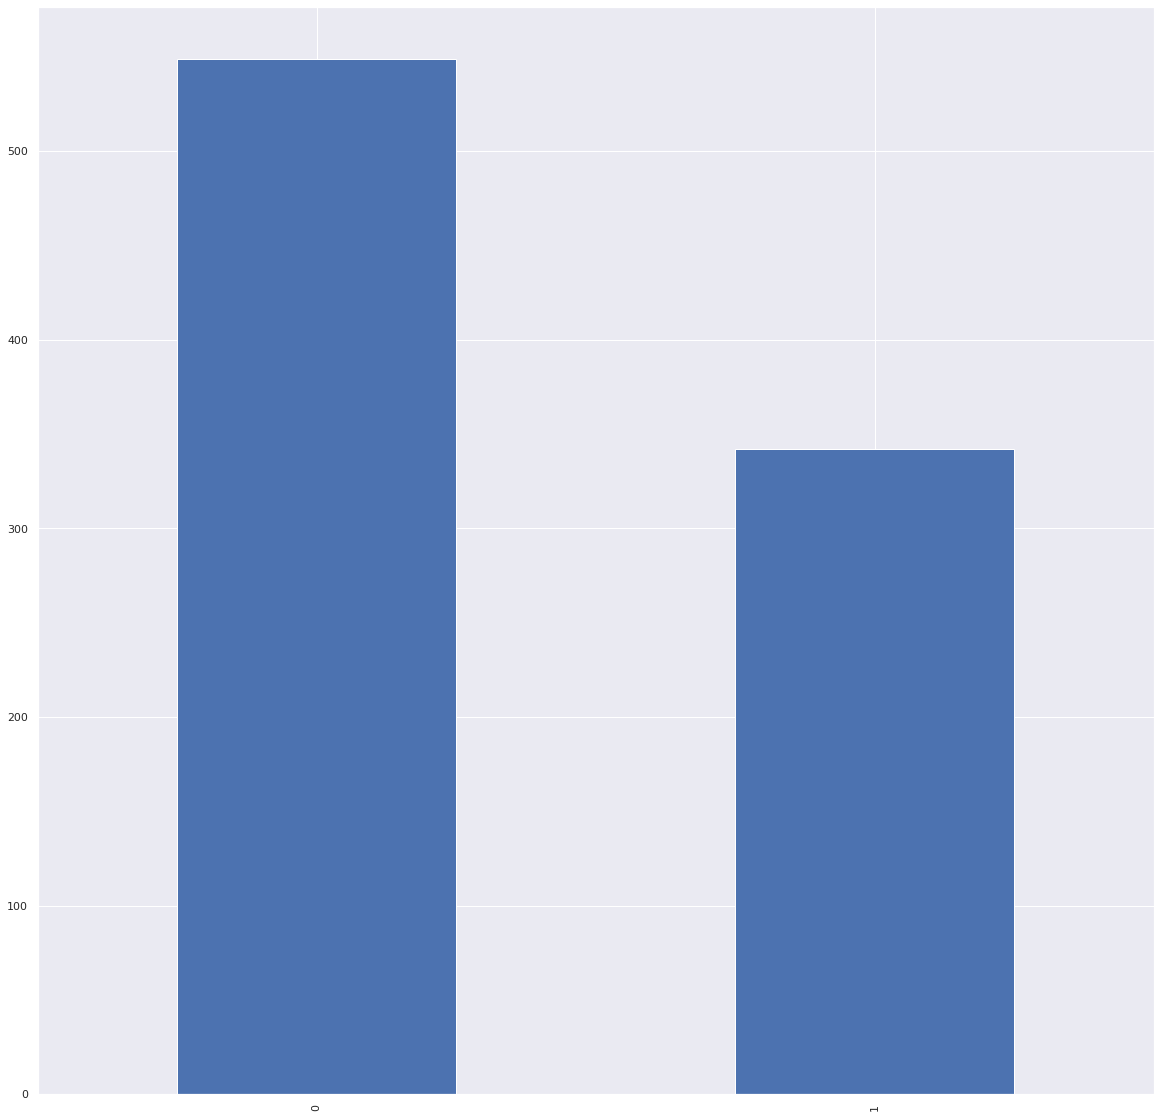

In [17]:
train['Survived'].value_counts().plot(kind='bar');

/home/gianlucca/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


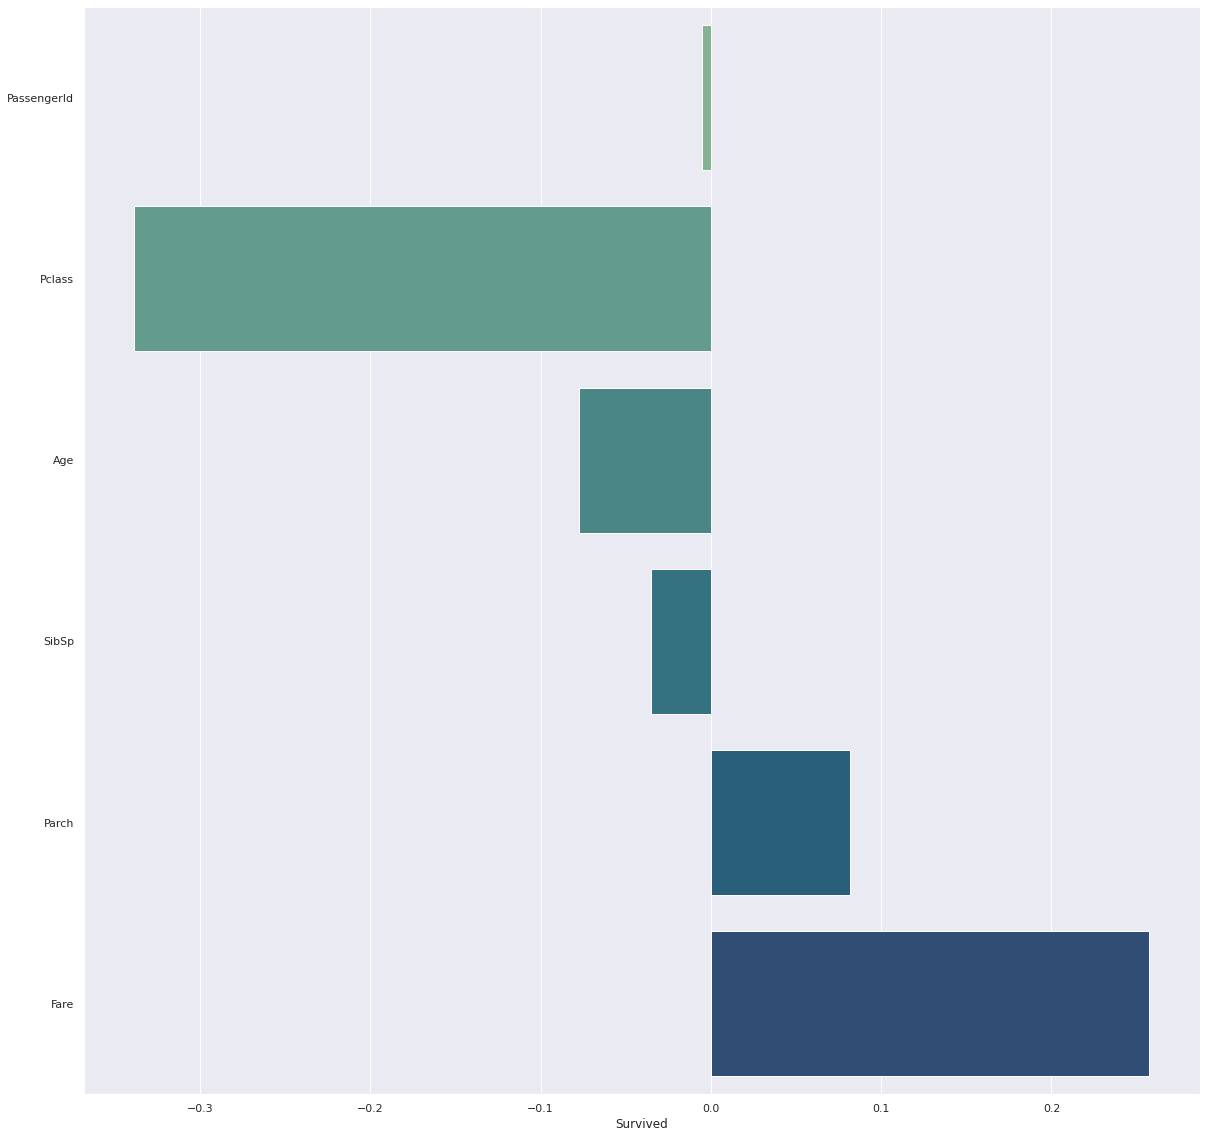

In [22]:
aux_corr = corr['Survived'].drop('Survived');
sns.barplot(
    aux_corr, 
    aux_corr.index, palette='crest');

/home/gianlucca/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/home/gianlucca/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

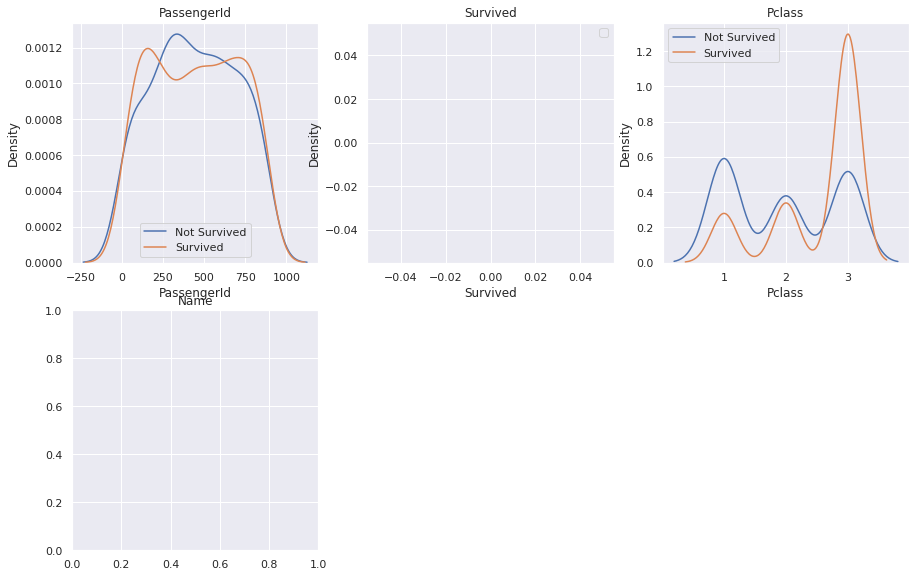

In [27]:
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

plt.figure(figsize = (15,15))
for ax,col in enumerate(train.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    sns.kdeplot(x = survived[col], label="Not Survived")
    sns.kdeplot(x = not_survived[col], label="Survived")
    plt.legend()
plt.tight_layout()